<a href="https://colab.research.google.com/github/elenshahbazyan/CNN/blob/main/House_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_csv('Housing.csv')

# Fill missing values
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# One-hot encoding for categorical features
df = pd.get_dummies(df, drop_first=True)

# Separate features (X) and target (y)
X = df.drop(columns='price')  # Assuming 'price' is the target variable
y = df['price']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split data into train, validation, and test sets (70-15-15 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Define the Neural Network architecture
class HousePriceNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(HousePriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
hidden_layers = [128, 256, 512]

# Grid search for hyperparameters
best_model = None
best_params = None
best_r2 = -np.inf
best_rmse = float('inf')

In [ ]:
# Perform grid search over hyperparameters
for lr in learning_rates:
    for hidden1 in hidden_layers:
        for hidden2 in hidden_layers:
            print(f"Training with lr={lr}, hidden1={hidden1}, hidden2={hidden2}")

            # Initialize the model, loss function, and optimizer
            input_size = X_train.shape[1]
            model = HousePriceNN(input_size, hidden1, hidden2)
            criterion = nn.MSELoss()  # Mean Squared Error for regression
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Store losses for plotting
            epoch_train_losses = []
            epoch_val_losses = []

            # Train the model
            epochs = 500
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                # Forward pass
                y_pred_train = model(X_train)
                train_loss = criterion(y_pred_train, y_train)

                # Backward pass
                train_loss.backward()
                optimizer.step()

                # Store training loss
                epoch_train_losses.append(train_loss.item())

                # Validation loss
                model.eval()
                with torch.no_grad():
                    y_pred_val = model(X_val)
                    val_loss = criterion(y_pred_val, y_val)

                # Store validation loss
                epoch_val_losses.append(val_loss.item())

            # Evaluate the model
            model.eval()
            with torch.no_grad():
                y_pred_train = model(X_train).numpy()
                y_pred_val = model(X_val).numpy()
                y_pred_test = model(X_test).numpy()

                y_train_np = y_train.numpy()
                y_val_np = y_val.numpy()
                y_test_np = y_test.numpy()

                rmse = np.sqrt(criterion(torch.tensor(y_pred_val), y_val).item())

                r2_train = r2_score(y_train_np, y_pred_train)
                r2_val = r2_score(y_val_np, y_pred_val)
                r2_test = r2_score(y_test_np, y_pred_test)

            # Track the best model based on validation R²
            if r2_val > best_r2:
                best_r2 = r2_val
                best_rmse = rmse
                best_model = model
                best_params = {'lr': lr, 'hidden1': hidden1, 'hidden2': hidden2}
                best_train_loss = epoch_train_losses[-1]
                best_val_loss = epoch_val_losses[-1]
                best_r2_train = r2_train
                best_r2_val = r2_val
                best_r2_test = r2_test

Training with lr=0.001, hidden1=128, hidden2=128
Training with lr=0.001, hidden1=128, hidden2=256
Training with lr=0.001, hidden1=128, hidden2=512
Training with lr=0.001, hidden1=256, hidden2=128
Training with lr=0.001, hidden1=256, hidden2=256
Training with lr=0.001, hidden1=256, hidden2=512
Training with lr=0.001, hidden1=512, hidden2=128
Training with lr=0.001, hidden1=512, hidden2=256
Training with lr=0.001, hidden1=512, hidden2=512
Training with lr=0.01, hidden1=128, hidden2=128
Training with lr=0.01, hidden1=128, hidden2=256
Training with lr=0.01, hidden1=128, hidden2=512
Training with lr=0.01, hidden1=256, hidden2=128
Training with lr=0.01, hidden1=256, hidden2=256
Training with lr=0.01, hidden1=256, hidden2=512
Training with lr=0.01, hidden1=512, hidden2=128
Training with lr=0.01, hidden1=512, hidden2=256
Training with lr=0.01, hidden1=512, hidden2=512
Training with lr=0.1, hidden1=128, hidden2=128
Training with lr=0.1, hidden1=128, hidden2=256
Training with lr=0.1, hidden1=128

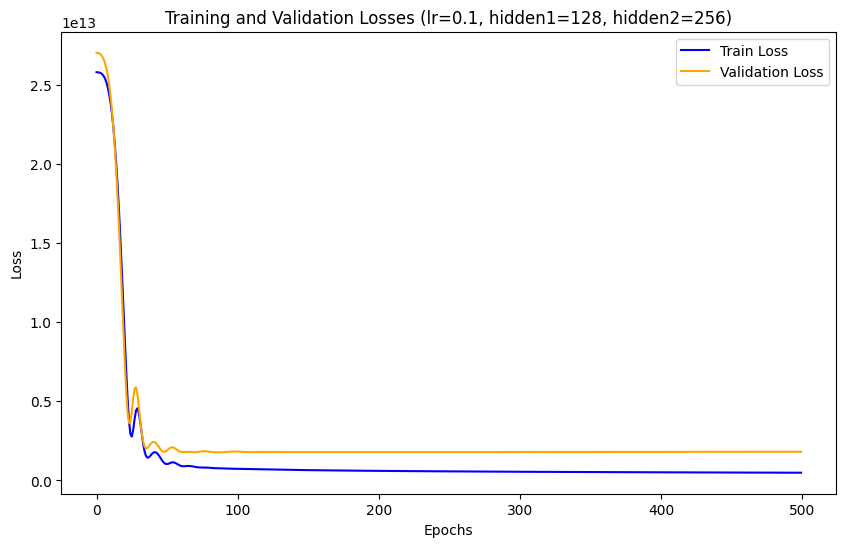

In [ ]:
# Plot the training and validation losses for the best model
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_losses, label='Train Loss', color='blue')
plt.plot(epoch_val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training and Validation Losses (lr={best_params["lr"]}, hidden1={best_params["hidden1"]}, hidden2={best_params["hidden2"]})')
plt.show()

In [ ]:
# Print best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {best_params}")
print(f"Train R²: {best_r2_train:.4f}")
print(f"Validation R²: {best_r2_val:.4f}")
print(f"Test R²: {best_r2_test:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Final Training Loss: {best_train_loss:.4f}")
print(f"Final Validation Loss: {best_val_loss:.4f}")

Best Hyperparameters: {'lr': 0.1, 'hidden1': 128, 'hidden2': 256}
Train R²: 0.8219
Validation R²: 0.5855
Test R²: 0.6602
Best RMSE: 1338070.2469
Final Training Loss: 559891480576.0000
Final Validation Loss: 1790431985664.0000


In [ ]:
# Save the best model
torch.save(best_model.state_dict(), 'best_house_price_model.pth')


In [ ]:
# Load the model
model = HousePriceNN(input_size, hidden1, hidden2)  # Define the model architecture first
model.load_state_dict(torch.load('best_house_price_model.pth'))
model.eval()  # Set the model to evaluation mode
